# Modèle de membrane couplée à une cavité
Soit $\eta(r,t)$ le déplacement de la membrane au point $r$ et au temps $t$. En considérant une pression homogène dans la cavitée, l'équation des ondes donne

$$
\Delta \eta - \frac{1}{c^2} \ddot \eta = \frac{\rho_0 c}{V_0 T}2\pi^2 \int_0^a \eta~~ \text d r,
$$

Ce qui peut s'approximer via la méthode des **différences finies** par

$$
\frac{1}{\Delta r^2} (\eta_{r+} + \eta_{r-} - 2 \eta_{r}) + \frac{1}{r\Delta r} (\eta_{r+} - \eta_{r}) - \frac{1}{c^2\Delta t^2}(\eta_{t+} + \eta_{t-} - 2 \eta_{t}) = \frac{\rho_0 c}{V_0 T} 2\pi^2\int_0^a \eta~~ \text d r
$$

In [1]:
import numpy as np

rho0 = 1.225              # Masse volumique de l'air au niveau de la mer
T    = 10000              # Tension appliquée à la membrane
a    = 16.5e-2            # Rayon de la membrane
surf = a**2 * np.pi       # Surface de la membrane
sig  = 50e-3 / surf       # Masse surfacique de la membrane
V0   = surf * 23e-2       # Volume de la cavité
c    = np.sqrt(T/sig)     # Célérité des ondes dans la membrane

params = {"rho":rho0, "T":T, "a":a, "surf":surf, "sig":sig, "V0":V0, "c":c}

for p in params:
    print("{:6s} : {:.2E}".format(p, params[p]))

rho    : 1.23E+00
T      : 1.00E+04
a      : 1.65E-01
surf   : 8.55E-02
sig    : 5.85E-01
V0     : 1.97E-02
c      : 1.31E+02


### Implémentation du schéma numérique
De manière à implémenter les conditions au bord de la membrane, on va forcer son déplacement à 0 pour $r=a$.

In [17]:
fs = 20000
dt = 1/fs

fs_r = 100
dr   = 1/fs_r

assert c**2*dt**2/dr**2 < 1, "Scheme instable. Increase time resolution"



r = np.linspace(0,1,fs_r)

duree = 1

eta = np.zeros([fs_r, duree*fs])

eta[:, 0] = .5*(np.cos(np.linspace(0,np.pi,fs_r))+1)/100
eta[:, 1] = eta[:, 0]

print("00", end=" ")

def dfdx2(x,dx):
    x_ = np.pad(np.pad(x, (1,0), "reflect"),(0,1), "reflect")
    return 1/dx**2 * (x_[2:] + x_[:-2] - 2*x_[1:-1])

def dfdx(x,dx):
    x_ = np.pad(x, (1,0), "reflect")
    return 1/dx * (x_[1:] - x_[:-1])



for t in range(1,duree*fs-1):
    
    if t%(int(duree*fs)//10)==0:
        print("{:02d}".format(int(t/(duree*fs)*100)), end=" ", flush=True)
    
    alpha = dfdx2(eta[:,t], dr)
    
    eta[:, t+1] = c**2 * dt**2 * (alpha) - eta[:, t-1] + 2 * eta[:, t]
    eta[-1, t+1]= 0
    

00 10 20 30 40 50 60 70 80 90 

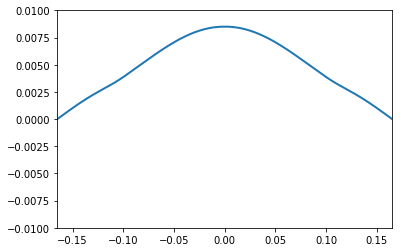

In [18]:
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( -a, a))
ax.set_ylim((-1e-2, 1e-2))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)


# animation function. This is called sequentially
def animate(i):
    x = np.linspace(-a, a, 2*fs_r)
    y = np.concatenate([np.flip(eta[:,10*i]),eta[:,10*i]])
    line.set_data(x, y)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=300, interval=20, blit=True)

HTML(anim.to_html5_video())


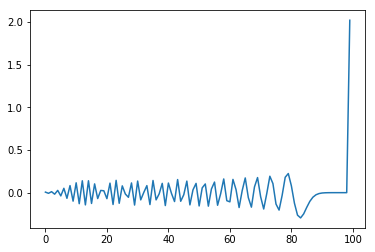

In [10]:
plt.plot(dfdx2(eta[:,130], dr))